In [1]:
import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
from cartopy import crs, feature
import pandas as pd
import seaborn as sns
import glob

In [2]:
Path = '/media/kenz/1B8D1A637BBA134B/bcsd-final/data2/'
Path2 = '/media/kenz/1B8D1A637BBA134B/calculated/'

In [3]:
bounds = [-3.5, 1.5, 4.5, 11.5]

In [4]:
ds = xr.open_dataset(Path + 'pr_GHA-22_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_GERICS-REMO2015_v1_day_20060101-21001231.nc')
ds_85 = xr.open_dataset(Path + 'pr_GHA-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_day_20060101-21001231.nc')
# ds_c = xr.open_dataset(Path2 + 'trans_chirpsera5_1991_2020.nc')
# ds_mpi = xr.open_dataset(Path2 + 'trans_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_1991_2025.nc')
# ds_nor = xr.open_dataset(Path2 + 'trans_NCC-NorESM1-M_rcp26_GERICS-REMO2015_1991_2025.nc')
# ds_mpi_85 = xr.open_dataset(Path2 + 'trans_MPI-M-MPI-ESM-LR_rcp85_GERICS-REMO2015_2026_2055.nc')
# ds_nor85 = xr.open_dataset(Path2 + 'trans_NCC-NorESM1-M_rcp85_GERICS-REMO2015_1991_2025.nc')
# mpi_26 = xr.open_dataset(Path2 + '../Mpi/RR_Tm_GHA-22_MPI-M-MPI-ESM-LR_historical_rcp26_r1i1p1_GERICS-REMO2015_v1_day_19710101-21001231.nc')
mpi_85 = xr.open_dataset(Path2 + '../Mpi/RR_Tm_GHA-22_MPI-M-MPI-ESM-LR_historical_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19710101-21001231.nc')
# data = glob.glob(Path2 + '*1991_2025.nc')
mal_data = glob.glob(Path2+'trans*rcp26*.nc')

In [5]:
ds_chirps = xr.open_dataset(Path + 'Ghana_chirps.nc')

In [6]:
colb = 'rainbow'
vm = 900
vx = 2250
def selonlat(ds):
    return(ds.sel(longitude = slice(bounds[0], bounds[1]), 
                  latitude = slice(bounds[2], bounds[3])))

def coords(ds):
    ds_ = ds.pr.drop_vars('lon').drop_vars('lat')
    ds_ = ds_.rename({'rlon':'longitude','rlat':'latitude'})
    return(ds_.to_dataset())

def clim_rain(data):
    return data.groupby('time.year').sum('time').mean('year')

def srai(ds):
    tol_sum = ds.groupby('time.year').sum('time').mean('year')
    mon_mean = tol_sum/12
    month = ds.resample(time='1M').sum().groupby('time.month').mean('time')
    return ((abs(month-mon_mean)).sum('month'))/tol_sum

def add_map(ax):
    ax.coastlines()
    ax.add_feature(feature.BORDERS)

def figures(ds1,ds2):
    fig, axes = plt.subplots(ncols = 3, subplot_kw={'projection':crs.PlateCarree()})
    chirps = selonlat(ds1.sel(time = slice('1990', '2020'))).precip
    clim_rain(chirps).plot(ax=axes[0], add_colorbar=False, vmax = vx, cmap=colb, vmin=vm)
    title = ['Historical'+ ' 1990-2020','Near Future'+ ' 2025-2055', 'Far Future'+' 2065-2085']
    rcp26 = clim_rain(selonlat(coords(ds2)).sel(time = slice('2025', '2055')).pr*86400)
    rcp26.where(rcp26 <=2500).plot(ax=axes[1], add_colorbar=False, cmap = colb, vmin=vm, vmax=vx)
    rcp85 = clim_rain(selonlat(coords(ds2)).sel(time = slice('2065', '2085')).pr*86400)
    cb = rcp85.where(rcp85 <=2500).plot(ax=axes[2], add_colorbar=False, cmap=colb, vmin=vm, vmax=vx)
    cax = fig.add_axes([0.95,0.43,0.02, 0.45])
    fig.colorbar(cb, cax = cax, orientation='vertical')
    for i,j in enumerate(axes):
        axes[i].set_extent(bounds)
        axes[i].set_title(title[i], fontsize = 9)
        axes[i].add_feature(feature.COASTLINE)
        axes[i].add_feature(feature.BORDERS)
        axes[i].add_feature(feature.STATES)
        axes[i].add_feature(feature.BORDERS)
    plt.suptitle('Rainfall climatology current and future ('+ds2.experiment_id[0:]+')')
    plt.subplots_adjust(top=1.2)
    
def srai_fig(ds1,ds2):
    fig, axes = plt.subplots(ncols = 3, subplot_kw={'projection':crs.PlateCarree()})
    chirps = srai(selonlat(ds1.sel(time = slice('1990', '2020'))).precip)
    chirps.plot(ax=axes[0], add_colorbar=False)
    title = ['Historical'+ ' 1990-2020','Near Future'+ ' 2025-2055', 'Far Future'+' 2065-2085']
    rcp26 = selonlat(coords(ds2)).sel(time = slice('2025', '2055')).pr*86400
    srai(rcp26).plot(ax=axes[1], add_colorbar=False)
    # rcp85 = selonlat(coords(ds)).sel(time = slice('2065', '2085')).pr*86400
    # cb = srai(rcp85).plot(ax=axes[2], add_colorbar=False)
    ff = selonlat(coords(ds2)).sel(time = slice('2065', '2085')).pr*86400
    cb = srai(ff).plot(ax=axes[2], add_colorbar=False)
    cax = fig.add_axes([0.95,0.38,0.02, 0.45])
    fig.colorbar(cb, cax = cax, orientation='vertical')
    for i,j in enumerate(axes):
        axes[i].set_extent(bounds)
        axes[i].set_title(title[i], fontsize = 9)
        axes[i].add_feature(feature.COASTLINE)
        axes[i].add_feature(feature.BORDERS)
        axes[i].add_feature(feature.STATES, linewidth = 0.2)
    plt.suptitle('Seasonality Index (SI), ('+ds2.experiment_id[0:]+ ') \n Walsh and Lawler (1981)')
    plt.subplots_adjust(top=1.1)
# plt.savefig('.jpeg')

In [ ]:
#figures(ds_chirps,ds_85)

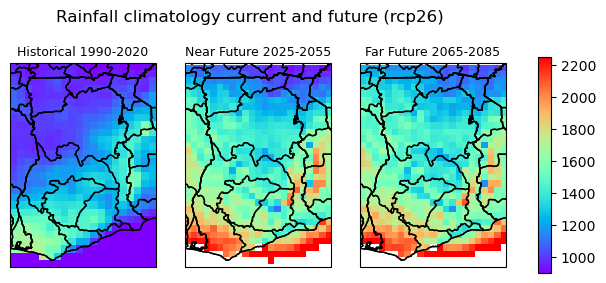

In [189]:
figures(ds_chirps, ds)

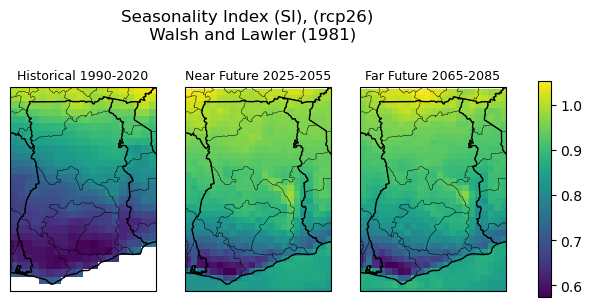

In [193]:
srai_fig(ds_chirps,ds)


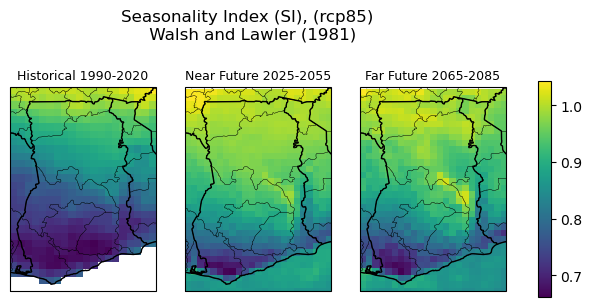

In [191]:
srai_fig(ds_chirps,ds_85)
# plt.savefig('c.eps')

In [194]:
%%html
<style>
table {float:left}
</style>

| Seasonality Index | Precipitation regime |
| :-: | :- |
| 0.19 | Precipitation spread throughout the year |
| 0.20-0.39 | Precipitation spread throughout the year, but with a definite wetter season |
| 0.40-0.59 | Rather seasonal with a short drier season |
| 0.60-0.79 | Seasonal |
| 0.80-0.99 | Marked seasonal with a long dry season |
| 1.00-1.19 | Most precipitation in <3 months |
| 1.20 | Extreme seasonality, with almost all precipitation in 1-2 months |


In [ ]:
# fig, axes = plt.subplots(ncols = 3, subplot_kw={'projection':crs.PlateCarree()}, figsize=(10,5))
# all_data = [ds_c,ds_mpi,ds_nor]
# for i, j in enumerate(all_data):
#     # j.eir.where(j.eir>0).plot(ax=axes[i], add_colorbar=False)
#     b = j.eir.where(j.eir>0).plot(ax=axes[i], add_colorbar=False, vmin=6)
#     axes[i].title.set_text(j.climfile[60:69]+j.climfile[-17:-7]+j.climfile[17:24])
#    # axes[i].set_title(title[i], fontsize = 9)
#     axes[i].add_feature(feature.COASTLINE)
#     axes[i].add_feature(feature.BORDERS)
#     axes[i].add_feature(feature.STATES, linewidth = 0.2)
# cax = fig.add_axes([0.99,0.1,0.02, 0.8])
# fig.colorbar(b, cax = cax, orientation='vertical')
# fig.tight_layout()

In [ ]:
# ds_c.eir.where(ds_c.eir>0).plot()
# ds_mpi.climfile[41:46]+ds_mpi.climfile[60:69]
ds_mpi.climfile[17:24]
# j.climfile[3:46]+j.climfile[60:69]

In [ ]:
data

In [ ]:
fig, axes = plt.subplots(ncols = 2, nrows =2, subplot_kw={'projection':crs.PlateCarree()}, figsize=(10,12))
axes = axes.flatten()
for i, j in enumerate(data):
    # print(i,j)
    if i%2 == 0:
        xr.open_dataset(j).eir.plot(ax = axes[i], add_colorbar = False)
        axes[i].title.set_text(j[-45:-38]+j[-22:-17]+' '+j[-12:-3]+' '+'('+j[-34:-29]+')')
    else:
        b = xr.open_dataset(j).eir.plot(ax = axes[i], add_colorbar = False)        
        axes[i].title.set_text(j[-45:-38]+j[-22:-17]+' '+j[-12:-3]+' '+'('+j[-34:-29]+')')
    axes[i].set_extent(bounds)
    axes[i].add_feature(feature.COASTLINE)
    axes[i].add_feature(feature.BORDERS)
    axes[i].add_feature(feature.STATES, linewidth = 0.2)    
cax = fig.add_axes([0.99,0.1,0.04, 0.8])
fig.colorbar(b, cax = cax, orientation='vertical')
plt.suptitle('Months of Malaria Transmission', fontweight='bold')
fig.tight_layout()
# /media/kenz/1B8D1A637BBA134B/calculated/treans_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_2026_2055.nc

In [ ]:
# axes[i].title.set_text(j.climfile[60:69]+j.climfile[-17:-7]+j.climfile[17:24])
# j[-44:-38]+j[-22:-3]
# data
# j[-44:-38]+j[-22:-17]+' '+j[-12:-3]+' '+'('+j[-34:-29]+')'

In [ ]:
f = coords(ds_85).sel(longitude=0, latitude=6, method='nearest').resample(time='M').sum('time').pr*86400
# pd.DataFrame(columns = [f.])
df = f.to_dataframe()
# df.time.year

In [ ]:
fig = plt.figure(figsize=(10,5))
heatmap1_data = pd.pivot_table(df, values='pr', index=df.index.month, columns=df.index.year)
ax1 = fig.add_subplot(1,1,1)
ax1=sns.heatmap(heatmap1_data, cmap="coolwarm", vmax=650)  ##### plot
# labels=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV','DEC']
# ax1.invert_yaxis()
# ax1.set_yticklabels(labels,rotation=45)
# heatmap1_data

In [ ]:
coords(ds_85).sel(longitude=0, latitude=6, method='nearest').pr.groupby('time.year').sum().plot()

In [ ]:
plt.figure()
dd = mpi_85.sel(longitude=0, latitude=11, method='nearest').rain.groupby('time.year').sum()
y = pd.DataFrame(dd).rolling(5).mean()
y1 = dd.values
x = dd.year.values
plt.plot(x,y, label = 'rolling mean')
plt.plot(x,y1, label = 'rain')
plt.legend()

# temperature.rolling(window=7).mean()

In [ ]:
def SRA(y):
    RR = y.Rainfall
    RR_df = pd.DataFrame(RR)
    RR_df['date']=pd.date_range(start='1980-01-01', end='2020-12-31',freq='M')
    RR_df=RR_df.set_index('date')
    R=RR_df.sub(RR_df.groupby([RR_df.index.month]).transform('mean'))
    std=RR_df.groupby([RR_df.index.month]).transform(np.std)
    return(R/std)

In [ ]:
# def calx(data):
#     data = data.sel(time=slice('1991','2020')).rain
#     y_data = data.groupby('time.year').sum()
#     y_mean = y_data.mean()
#     y_std = y_data.std()
#     anom = (y_data-y_mean)/y_std
#     anom_avg = (sum(anom)/len(anom))
#     return anom_avg
# a = calx(mpi_26)
# a.to_netcdf('mpi_ano_26.nc')
# b = calx(mpi_85)
# b.to_netcdf('mpi_ano_85.nc')

In [ ]:
def calx(data):
    data = data.sel(time=slice('1991','2020')).tas
    y_data = data.groupby('time.year').sum()
    y_mean = y_data.mean()
    y_std = y_data.std()
    anom = (y_data-y_mean)/y_std
    anom_avg = (sum(anom)/len(anom))
    return anom_avg
#a = calx(mpi_26)
#a.to_netcdf('mpi_ano_26.nc')
def cala(data):
    data = data.sel(time=slice('2031','2060')).tas
    y_data = data.groupby('time.year').sum()
    y_mean = y_data.mean()
    y_std = y_data.std()
    anom = (y_data-y_mean)/y_std
    anom_avg = (sum(anom)/len(anom))
    return anom_avg
def calb(data):
    data = data.sel(time=slice('2061','2090')).tas
    y_data = data.groupby('time.year').sum()
    y_mean = y_data.mean()
    y_std = y_data.std()
    anom = (y_data-y_mean)/y_std
    anom_avg = (sum(anom)/len(anom))
    return anom_avg
#a = calx(mpi_26)
#a.to_netcdf('mpi_ano_26.nc')
x = calx(mpi_85)
x.to_netcdf('mpi_ano_85_1991_t.nc')
a = cala(mpi_85)
a.to_netcdf('mpi_ano_85_2031_t.nc')
b = calb(mpi_85)
b.to_netcdf('mpi_ano_85_2061_t.nc')

In [ ]:
# def plot_rainfall_on_map(ds1,ds2,ds3):
    
#     ds1 = xr.open_dataset(ds1)
#     ds2 = xr.open_dataset(ds2)
#     ds3 = xr.open_dataset(ds3)
    
#     latitude = ds1['latitude']
#     longitude = ds1['longitude']
#     ds1 = ds1['rain']
#     ds2 = ds2['rain']
#     ds3 = ds3['rain']
#     fig, axes = plt.subplots(ncols = 3, figsize = (25,9),subplot_kw={'projection':crs.PlateCarree()})
#     ds1.plot(ax=axes[0], add_colorbar=False,cmap='viridis',**cbar_kwargs) #colormap = 'coolwarm')
    
#     ds2.plot(ax=axes[1], add_colorbar=False,cmap='viridis')
#     title = ['MPI_85 Anomalies'+ ' 1991-2020','MPI_85 Anomalies'+ ' 2031-2060','MPI_85 Anomalies'+ ' 2061-2090']
#     ds3.plot(ax=axes[2], add_colorbar=False,cmap='viridis')
#     #cax = fig.add_axes([0.95,0.38,0.02, 0.45])
#     #fig.colorbar(cb, cax = cax, orientation='vertical',label= 'Rainfall Anomalies')
#     for i,j in enumerate(axes):
#         axes[i].set_extent(bounds)
#         axes[i].set_title(title[i], fontsize = 9)
#         axes[i].add_feature(feature.COASTLINE)
#         axes[i].add_feature(feature.BORDERS)
#         axes[i].add_feature(feature.STATES, linewidth = 0.2)
    
#     plt.subplots_adjust(top=1.1)
# # plt.savefig('.jpeg')

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as feature

def plot_rainfall_on_map(ds1, ds2, ds3):
    # Open the xarray datasets
    ds1 = xr.open_dataset(ds1)
    ds2 = xr.open_dataset(ds2)
    ds3 = xr.open_dataset(ds3)
    
    # Extract latitude, longitude, and rainfall data variables from each dataset
    latitude = ds1['latitude']
    longitude = ds1['longitude']
    ds1 = ds1['tas']
    ds2 = ds2['tas']
    ds3 = ds3['tas']
    vx=1.5
    vn=-1.5
    
    # Create a 1x3 subplot layout with PlateCarree projection for each subplot
    fig, axes = plt.subplots(ncols=3, figsize=(15, 9), subplot_kw={'projection': crs.PlateCarree()})
    
    # Plot each dataset on a separate subplot
    ds1_plot = ds1.plot(ax=axes[0], add_colorbar=False, cmap='viridis',vmax=vx,vmin=vn)
    ds2_plot = ds2.plot(ax=axes[1], add_colorbar=False, cmap='viridis',vmax=vx,vmin=vn)
    ds3_plot = ds3.plot(ax=axes[2], add_colorbar=False, cmap='viridis',vmax=vx,vmin=vn)
    
    # Set the titles for each subplot
    title = ['MPI_85 Anomalies 1991-2020', 'MPI_85 Anomalies 2031-2060', 'MPI_85 Anomalies 2061-2090']
    for i, ax in enumerate(axes):
        ax.set_title(title[i], fontsize=9)
        
        # Add map features to each subplot (coastlines, borders, and states)
        ax.add_feature(feature.COASTLINE)
        ax.add_feature(feature.BORDERS)
        ax.add_feature(feature.STATES, linewidth=0.2)
        
        # Define the extent of the map. This assumes that you have a variable named "bounds."
        # Replace the following line with the appropriate bounds based on your dataset and region.
        # bounds = [min_longitude, max_longitude, min_latitude, max_latitude]
        # ax.set_extent(bounds)
        
    # Add individual colorbars to each subplot
    cbar_kwargs = {
        'orientation': 'vertical',
        'fraction': 0.05,  
        'pad': 0.04,       
    }
    VAR = 'T-anomalies'
    cbar1 = plt.colorbar(ds1_plot, ax=axes[0], **cbar_kwargs,label= VAR)
    cbar2 = plt.colorbar(ds2_plot, ax=axes[1], **cbar_kwargs,label= VAR)
    cbar3 = plt.colorbar(ds3_plot, ax=axes[2], **cbar_kwargs,label= VAR)
    
    # Adjust the layout and save the plot
    plt.subplots_adjust(top=1.1)
    # plt.savefig('.jpeg')  # You can save the plot to a file if needed.
    plt.show()  




In [ ]:
plot_rainfall_on_map('mpi_ano_85_1991_t.nc','mpi_ano_85_2031_t.nc','mpi_ano_85_2061_t.nc')#'mpi_ano_85.nc')

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as feature
from matplotlib.gridspec import GridSpec

def plot_six_subplots(ds_list, var_names,titles):
    # Create the figure and GridSpec for arranging subplots
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.2)
    
    # Loop through each dataset and plot the subplots
    for i, ds in enumerate(ds_list):
        # Extract latitude, longitude, and data variables from the dataset
        latitude = ds['latitude']
        longitude = ds['longitude']
        if ds.da
        data = ds[var_names[i]]  # Replace 'data_variable' with the name of your data variable
        
        # Create a PlateCarree projection for the map
        projection = crs.PlateCarree()
        
        # Create the subplot axes
        ax = fig.add_subplot(gs[i])
        
        # Plot the data as a contour or heatmap
        levels = 10  # Number of contour levels or heatmap color levels
        cmap = 'viridis'  # Colormap for the plot
        data.plot.contourf(ax=ax, levels=levels, cmap=cmap, extend='both')
        # Alternatively, use the following line for a heatmap-like plot:
        # data.plot.pcolormesh(ax=ax, cmap=cmap)
        
        # Add map features (coastlines, borders, and states)
        ax.add_feature(feature.COASTLINE)
        ax.add_feature(feature.BORDERS)
        ax.add_feature(feature.STATES, linewidth=0.2)
        
        # Set the title for each subplot
        ax.set_title(titles[i], fontsize=9)
    
    # Add overall supertitle for each set of three subplots
    plt.suptitle('Spatial Distribution of Different Data Sets', fontsize=14)
    
    # Show the plot
    plt.show()

# Example usage:
# Replace 'ds_list' with a list of xarray datasets containing the data for each subplot
# Replace 'titles' with a list of titles for each set of three subplots
# plot_six_subplots(ds_list, titles)


In [ ]:
def read_d(data):
    data = xr.open_dataset(data)
    return data
a = read_d('mpi_ano_85_1991.nc')
b = read_d('mpi_ano_85_2031.nc')
c = read_d('mpi_ano_85_2061.nc')
d = read_d('mpi_ano_85_1991_t.nc')
e = read_d('mpi_ano_85_2031_t.nc')
f = read_d('mpi_ano_85_2061_t.nc')


In [ ]:
a = a.rain
if a.rain == True:
    print('yes')

In [ ]:
ds_list = [a,b,c,d,e,f]
titles = ['a','b','c','d','e','f']
plot_six_subplots(ds_list, titles)

In [ ]:


def plot_rainfall_on_map(ds1):
    
    ds1 = xr.open_dataset(ds1)
    

    
    latitude = ds1['latitude']
    longitude = ds1['longitude']
    ds1 = ds1['rain']
    

    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs.PlateCarree()})

    
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.add_feature(feature.STATES)
    ax.set_extent([-3.5, 1.2, 4.5, 11.5])  

   
    rainfall.plot(ax=ax, transform=crs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.7, 'label': 'Rainfall (mm)'})

    # Add a title
    ax.set_title('Rainfall anomalies in Ghana')

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Show the plot
    plt.show()


In [ ]:
plot_rainfall_on_map('mpi_ano_26.nc')

In [ ]:
pwd

In [11]:
mpi_85.tas.min()

<xarray.DataArray 'tas' ()>
array(14.905756)
Coordinates:
    height   float64 ...

In [12]:
c = mpi_85.sel(time= slice('1991','2020')).rain
# c.sub(c.groupby([c.index.month]).transform('mean'))
y_data = c.groupby('time.year').sum()
y_mean = y_data.mean()
y_std = y_data.std()
anom = (y_data-y_mean)/y_std
anom_avg = (sum(anom)/len(anom))

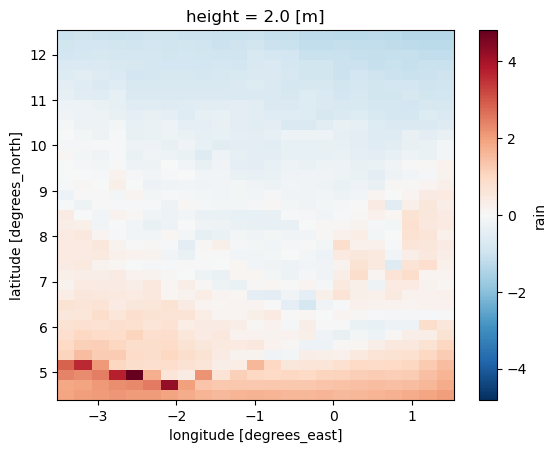

In [13]:
anom_avg.plot()

In [14]:
c = mpi_26.sel(time= slice('1991','2020')).rain
# c.sub(c.groupby([c.index.month]).transform('mean'))
y_data = c.groupby('time.year').sum()
y_mean = y_data.mean()
y_std = y_data.std()
anom = (y_data-y_mean)/y_std
anom_avg = (sum(anom)/len(anom))
anom_avg.plot()

NameError: name 'mpi_26' is not defined

In [140]:
mal_data

['/media/kenz/1B8D1A637BBA134B/calculated/trans_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_2061_2090.nc',
 '/media/kenz/1B8D1A637BBA134B/calculated/trans_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_1991_2020.nc',
 '/media/kenz/1B8D1A637BBA134B/calculated/trans_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_2031_2060.nc']

In [20]:
mal_eir = glob.glob(Path2+'E*rcp26*.nc')
mal_eir

['/media/kenz/1B8D1A637BBA134B/calculated/EIR_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_1991_2020.nc',
 '/media/kenz/1B8D1A637BBA134B/calculated/EIR_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_2031_2060.nc',
 '/media/kenz/1B8D1A637BBA134B/calculated/EIR_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_2061_2090.nc']

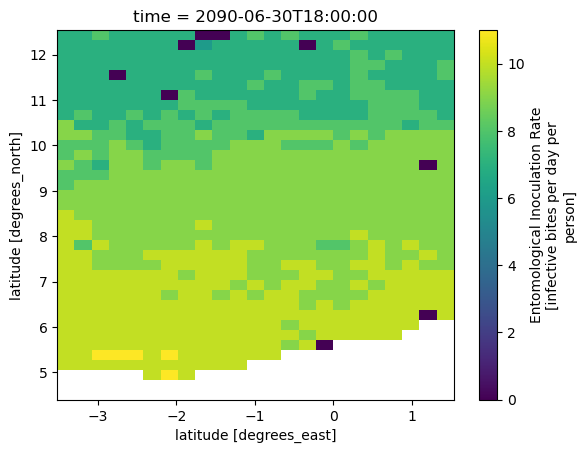

In [149]:
xr.open_dataset(mal_data[0]).eir.plot()

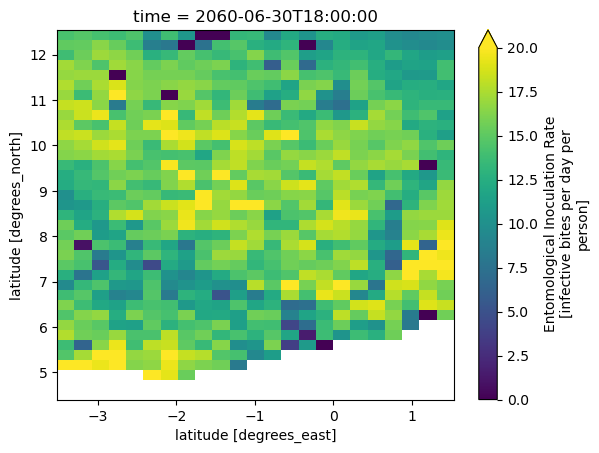

In [130]:
xr.open_dataset(mal_eir[1]).eir.plot(vmax=20, vmin=0)

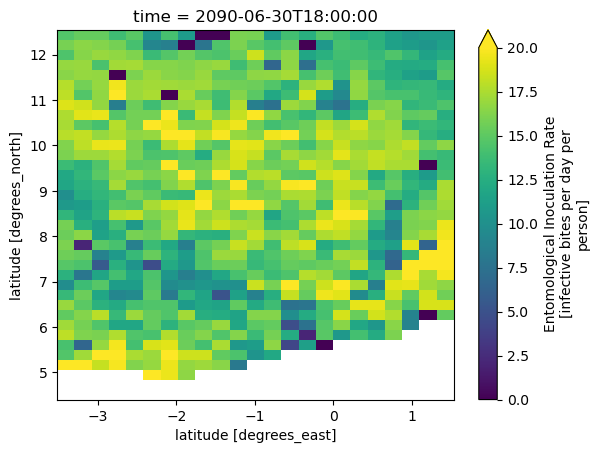

In [131]:
xr.open_dataset(mal_eir[2]).eir.plot(vmax=20,vmin=0)

/tmp/ipykernel_20807/121128423.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


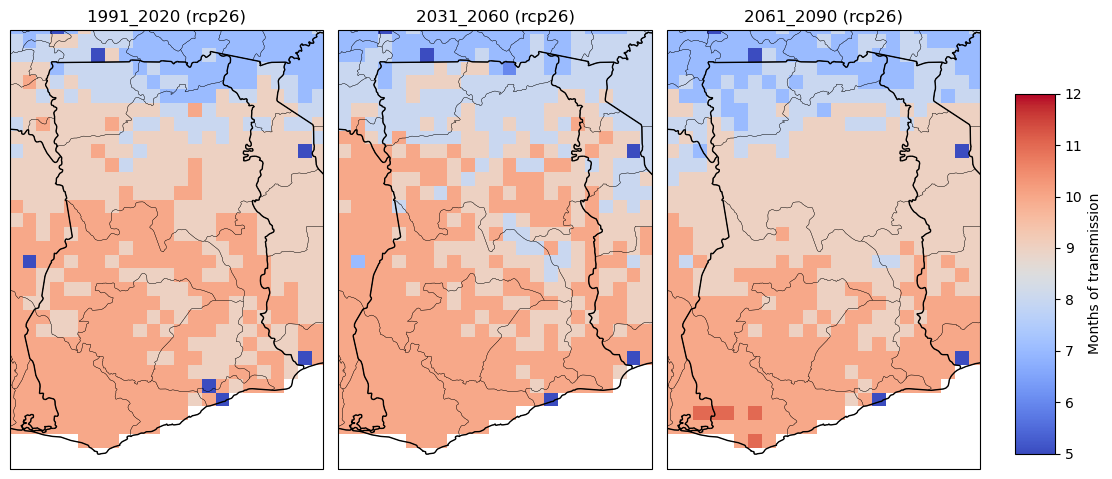

In [161]:
cm='coolwarm'
vm=12
vn=5
fig, axes = plt.subplots(ncols = 3, nrows =1, subplot_kw={'projection':crs.PlateCarree()}, figsize=(10,12))#, gridspec_kw={'hspace': -0.3, 'wspace': 0.2})
axes = axes.flatten()
for i, j in enumerate(mal_data):
    if i/1 == 0: 
        xr.open_dataset(j).eir.plot(ax = axes[2], add_colorbar = False, cmap=cm, vmax=vm, vmin=vn)
        axes[2].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')

    else:
        a=xr.open_dataset(j).eir.plot(ax = axes[i-1], add_colorbar = False, cmap=cm, vmax=vm, vmin=vn)
        axes[i-1].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')

# #cax1 = fig.add_axes([1.02,0.588,0.04, 0.3])
cax1 = fig.add_axes([1.02,0.33,0.04, 0.3])
fig.colorbar(a,cax=cax1, orientation='vertical',label='Months of transmission', cmap=cm)
# for i, j in enumerate(mal_eir):
#     x=xr.open_dataset(j)
#     b=x.eir.plot(ax = axes[3+i], add_colorbar = False,vmax=20,vmin=0)
#     axes[i+3].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')
# #cax2 = fig.add_axes([1.02,0.12,0.04, 0.3])
# cax2 = fig.add_axes([1.02,0.12,0.04, 0.3])
# fig.colorbar(b,cax=cax2, orientation='vertical', label = 'EIP')
for i,j in enumerate(axes):
    axes[i].set_extent(bounds)
    axes[i].add_feature(feature.COASTLINE)
    axes[i].add_feature(feature.BORDERS)
    axes[i].add_feature(feature.STATES, linewidth = 0.2)    
fig.tight_layout()

In [133]:
mal_eir85 = glob.glob(Path2+'E*rcp85*.nc')
mal_data85 = glob.glob(Path2+'trans*rcp85*.nc')

In [137]:
mal_eir85

['/media/kenz/1B8D1A637BBA134B/calculated/EIR_MPI-M-MPI-ESM-LR_rcp85_GERICS-REMO2015_1991_2020.nc',
 '/media/kenz/1B8D1A637BBA134B/calculated/EIR_MPI-M-MPI-ESM-LR_rcp85_GERICS-REMO2015_2031_2060.nc',
 '/media/kenz/1B8D1A637BBA134B/calculated/EIR_MPI-M-MPI-ESM-LR_rcp85_GERICS-REMO2015_2061_2090.nc']

/tmp/ipykernel_20807/2060508993.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


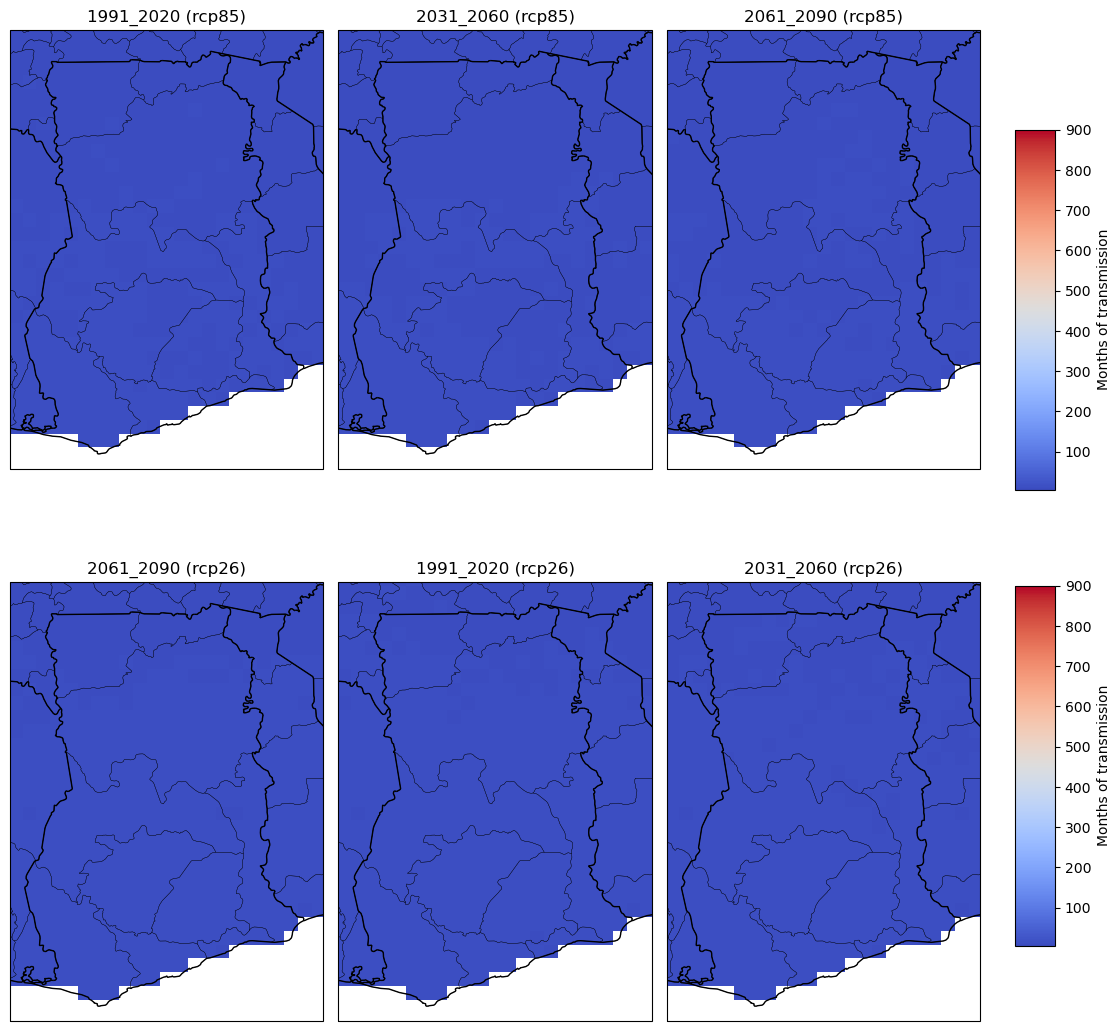

In [195]:
fig, axes = plt.subplots(ncols = 3, nrows =2, subplot_kw={'projection':crs.PlateCarree()}, figsize=(10,12))#, gridspec_kw={'hspace': -0.3, 'wspace': 0.2})
axes = axes.flatten()
for i, j in enumerate(mal_data85):
    a=xr.open_dataset(j).eir.plot(ax = axes[i], add_colorbar = False, cmap=cm, vmax=vm, vmin=6)
    axes[i].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')
#cax1 = fig.add_axes([1.02,0.588,0.04, 0.3])
cax1 = fig.add_axes([1.02,0.53,0.04, 0.3])
fig.colorbar(a,cax=cax1, orientation='vertical',label='Months of transmission', cmap=cm)

for i, j in enumerate(mal_data):
    if i/1 == 0: 
        xr.open_dataset(j).eir.plot(ax = axes[3], add_colorbar = False, cmap=cm, vmax=vm, vmin=vn)
        axes[3].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')
    else:
        b=xr.open_dataset(j).eir.plot(ax = axes[i+3], add_colorbar = False, cmap=cm, vmax=vm, vmin=vn)
        axes[i+3].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')

# #cax1 = fig.add_axes([1.02,0.588,0.04, 0.3])
cax1 = fig.add_axes([1.02,0.15,0.04, 0.3])
fig.colorbar(a,cax=cax1, orientation='vertical',label='Months of transmission', cmap=cm)



# for i, j in enumerate(mal_eir85):
#     x=xr.open_dataset(j)
#     b=x.eir.plot(ax = axes[3+i], add_colorbar = False,vmax=20,vmin=0)
#     axes[i+3].title.set_text(j[-12:-3]+' '+'('+j[-34:-29]+')')
# #cax2 = fig.add_axes([1.02,0.12,0.04, 0.3])
# cax2 = fig.add_axes([1.02,0.12,0.04, 0.3])
# fig.colorbar(b,cax=cax2, orientation='vertical', label = 'EIP')
for i,j in enumerate(axes):
    axes[i].set_extent(bounds)
    axes[i].add_feature(feature.COASTLINE)
    axes[i].add_feature(feature.BORDERS)
    axes[i].add_feature(feature.STATES, linewidth = 0.2)    
fig.tight_layout()